# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
!pip list

In [142]:
import tensorflow as tf
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [144]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [146]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [149]:
import cv2
import imghdr

In [151]:
data_dir = 'data' 

In [153]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [155]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data\happy\happyTest.jpg


# 3. Load Data

This function loads images from a directory ('data' in this case) and prepares them for training in TensorFlow.

It loads the images in batches of 32 (you'll have 32 images in each batch).

All images are resized to 224x224 pixels, which is a standard size for many deep learning models.

The shuffle=True option means the images are mixed randomly before creating the batches, so your model won't learn patterns based on the order of the images.

==========================================================

This line converts the data (which is a TensorFlow Dataset object) into a NumPy iterator.

A NumPy iterator lets you loop through the dataset and get the data in a format that's easier to handle, as NumPy arrays.

====================================================================

The .next() method fetches the next batch of images and their labels from the dataset.

This gives you a set of 32 images and their corresponding labels (since you set batch_size=32).

The images are stored in batch[0] and the labels in batch[1].

In [157]:
import numpy as np
from matplotlib import pyplot as plt

In [158]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 307 files belonging to 2 classes.


In [162]:
data_iterator = data.as_numpy_iterator()

In [164]:
batch = data_iterator.next()

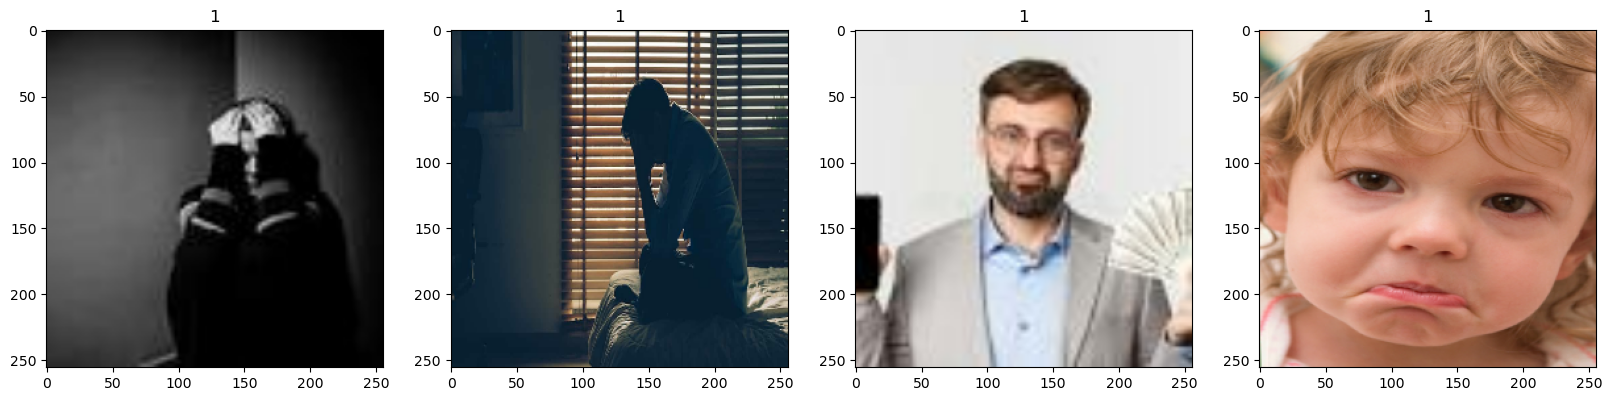

In [166]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

When you building deep learning models ideally you want values to be small as possible

Scailing the image value between 0 and 1 instead of 0 to 255 this helps our deep learning model

In [169]:
data = data.map(lambda x,y: (x/255, y))

In [171]:
data.as_numpy_iterator().next()

(array([[[[0.47941175, 0.7362745 , 0.73333335],
          [0.5019608 , 0.7411765 , 0.74509805],
          [0.5019608 , 0.7372549 , 0.7411765 ],
          ...,
          [0.82412684, 0.63589156, 0.73785233],
          [0.83457416, 0.6384957 , 0.7522212 ],
          [0.81807595, 0.62199754, 0.735723  ]],
 
         [[0.48235294, 0.73333335, 0.73333335],
          [0.5019608 , 0.7411765 , 0.74509805],
          [0.5019608 , 0.7372549 , 0.7411765 ],
          ...,
          [0.828125  , 0.6398897 , 0.7418505 ],
          [0.82470894, 0.6318781 , 0.74560356],
          [0.8279565 , 0.63512564, 0.7488511 ]],
 
         [[0.4978554 , 0.7370711 , 0.74099267],
          [0.5056985 , 0.74099267, 0.74491423],
          [0.50214463, 0.73743874, 0.7413603 ],
          ...,
          [0.8158701 , 0.6276348 , 0.7295956 ],
          [0.82464767, 0.6324908 , 0.7462163 ],
          [0.8312347 , 0.63907784, 0.7528033 ]],
 
         ...,
 
         [[0.9254902 , 0.88235295, 0.46666667],
          [0.92549

# 5. Split Data

We are going to split our data into training testing and validation to ebsure we dont overfit

In [174]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [176]:
train_size

7

In [178]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [181]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

Overall Summary:

1 The Conv2D layers extract features from the image.

2 The MaxPooling layers reduce the size of the image and focus on important features.

3 The Dense layers use these features to make predictions.

4 The ReLU activation helps with non-linearity.

5 The Sigmoid activation gives the final binary output.

6 In a Convolutional Neural Network (CNN), the stride determines how much the filter (or kernel) moves across the input image 
  during the convolution operation.

Stride of 1 means the filter moves 1 pixel at a time across the image.

In [183]:
model = Sequential()

In [185]:
# with activations we reshape our output


# What it does: Adds a Convolutional Layer with 16 filters. Each filter is of size 3x3 and moves with a stride of 1.
# Input shape: The input image size is 256x256 with 3 channels (RGB).
# ReLU Activation: It turns all negative values to zero and keeps positive values unchanged. This helps introduce non-linearity.

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
# What it does: Adds a Max Pooling Layer. It reduces the spatial size of the image (height and width) by taking the maximum value from a small region, usually 2x2.
# Why?: This helps reduce computation and extract the most important features.
model.add(MaxPooling2D())


# Why increase filters?: More filters allow the model to learn more complex patterns or features.
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


# Why reduce filters?: After extracting detailed features in earlier layers, fewer filters may be sufficient at this stage.
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


# What it does: Converts the 2D output of the previous layer into a 1D vector.
# This is required for the next Dense (fully connected) layers.
model.add(Flatten())

# What it does: Adds a fully connected layer with 256 neurons.
# combining the features extracted by earlier layers.
model.add(Dense(256, activation='relu'))
# What it does: Adds the final output layer with 1 neuron.
# Sigmoid Activation: Outputs a value between 0 and 1 (useful for binary classification).
# Why?: For binary classification (e.g., "yes/no" or "cat/dog"), the output is a probability.
model.add(Dense(1, activation='sigmoid'))

This prepares the model for training. You specify three things here:

1 - Optimizer

2 - Loss Function

3 - Metrics


Adam is an optimization algorithm that adjusts the learning rate automatically during training.
It helps the model learn faster and more efficiently.

===================================================================

loss=tf.losses.BinaryCrossentropy() (Loss Function)

Binary Crossentropy is used when the model does binary classification (two possible outputs, like 0 or 1).

It measures how far the predicted output is from the actual output (true labels).

The goal is to minimize this loss to make the predictions more accurate.

===================================================================

metrics=['accuracy']

Accuracy measures how many predictions the model gets correct.

It’s a simple metric to evaluate the model’s performance.

In [187]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [189]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# 7. Train

In [192]:
logdir='logs'

In [194]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [196]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
print("all test passed")

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 348ms/step - accuracy: 0.4843 - loss: 1.1890 - val_accuracy: 0.5469 - val_loss: 0.6459
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - accuracy: 0.4984 - loss: 0.6709 - val_accuracy: 0.7344 - val_loss: 0.6150
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.7382 - loss: 0.5957 - val_accuracy: 0.8125 - val_loss: 0.4832
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.7169 - loss: 0.5330 - val_accuracy: 0.6875 - val_loss: 0.6101
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.7127 - loss: 0.4777 - val_accuracy: 0.8438 - val_loss: 0.3353
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 348ms/step - accuracy: 0.8482 - loss: 0.3854 - val_accuracy: 0.9688 - val_loss: 0.2415
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.9043 - loss: 0.3032 - val_accuracy: 0.9531 - val_loss: 0.1920
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.9408 - loss: 0.1941 - val_accuracy: 0.9688 - val_loss:

# 8. Plot Performance

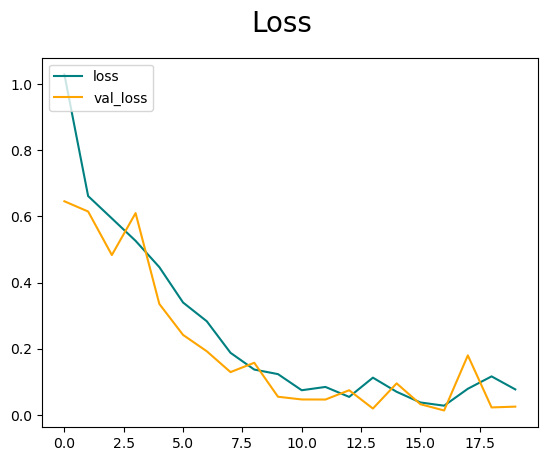

In [198]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

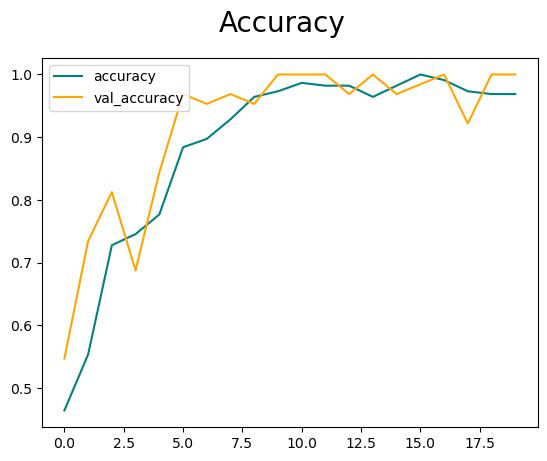

In [200]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Test

In [202]:
import cv2

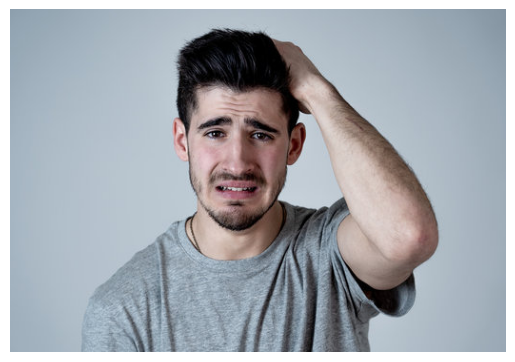

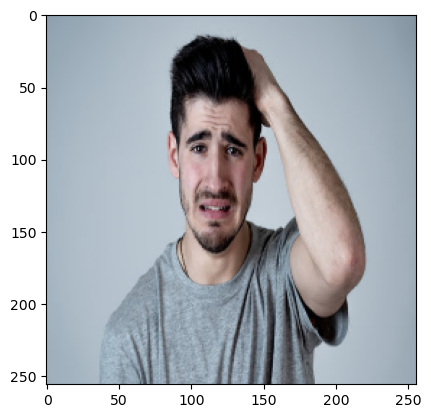

In [287]:
# img = cv2.imread('154006829.jpg')
# img = cv2.imread('data/happy/happyTest2.jpg')
# img = cv2.imread('data/happy/happyTest.jpg')
img = cv2.imread('data/sad/sadTest.jpg')
# img = cv2.imread('data/happy/superman.jpg')


convertedImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(convertedImg)
plt.axis('off')  
plt.show()

resize = tf.image.resize(convertedImg, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()



In [289]:
yhat = model.predict(np.expand_dims(resize/255, 0))

yhat


if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Predicted class is Sad


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))

In [46]:
new_model = load_model('imageclassifier.h5')

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)